In [1]:
subj = "Subj1"
exp = "exp_final"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = False

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas
import matplotlib.pyplot as plt

pandas.set_option("display.precision", 2)

### Data

In [3]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")

df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
df_all_features = pandas.read_feather(f"{subj}/{exp}/all_features.feather")

features = df_features.to_numpy()
print('Features: ', features.shape)
print('All features: ', df_all_features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 57)
All features:  (1046, 9875)


In [4]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    features = features[:-2]
    df_all_features = df_all_features[:-2]

### SDA

In [5]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 57 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [6]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
print(edges_true)

metrics = [ ]
for row in tqdm.tqdm(result['St_edges']):
    metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:07<00:00, 270.56it/s]


In [7]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [8]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

    return best_edges

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,35,20,3,Mode,"[0, 554, 682, 1046]",209857.23,45.56,2.87e-02,41.69,5.22,0.11,56.53,2.66,0.62,0.38,0.59
1,40,40,15,4,Median,"[0, 200, 554, 842, 1046]",80867.28,23.08,1.48e-02,29.39,6.65,0.04,23.99,5.93,0.67,0.48,0.60
2,60,50,15,5,Median,"[0, 200, 554, 682, 859, 1046]",167132.08,41.66,1.65e-02,38.77,5.26,0.10,48.37,2.94,0.76,0.57,0.66
3,0,40,20,6,Mode,"[0, 91, 203, 554, 682, 842, 1046]",134646.52,40.01,2.89e-03,34.84,4.72,0.10,39.05,2.98,0.74,0.53,0.62
4,0,35,15,7,Mode,"[0, 91, 203, 554, 682, 842, 976, 1046]",137133.11,42.99,6.45e-03,34.23,5.14,0.10,39.25,2.74,0.78,0.57,0.65
5,0,35,15,8,Mode,"[0, 91, 203, 342, 554, 682, 842, 976, 1046]",107324.08,38.21,1.55e-03,30.90,5.27,0.09,30.53,3.29,0.79,0.59,0.65
6,0,35,20,9,Mode,"[0, 91, 203, 282, 554, 682, 787, 842, 976, 1046]",89286.56,38.59,-6.79e-03,28.57,5.16,0.08,25.65,3.14,0.86,0.71,0.76
7,0,50,10,10,Mode,"[0, 91, 126, 248, 342, 459, 554, 682, 842, 976...",72206.73,32.61,-5.37e-03,25.06,5.44,0.08,20.21,3.98,0.79,0.60,0.66
8,20,45,20,11,Mode,"[0, 91, 126, 203, 282, 486, 554, 682, 787, 842...",58758.11,34.31,-1.01e-02,24.72,5.14,0.07,16.81,3.50,0.87,0.76,0.80
9,0,40,20,12,Mode,"[0, 91, 186, 203, 282, 486, 554, 682, 787, 842...",55137.25,38.62,-1.29e-02,22.65,4.68,0.08,15.84,3.09,0.87,0.77,0.80


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,35,20,9,Mode,"[0, 91, 203, 282, 554, 682, 787, 842, 976, 1046]",89286.56,38.59,-6.79e-03,28.57,5.16,0.08,25.65,3.14,0.86,0.71,0.76


array([   0,   91,  203,  282,  554,  682,  787,  842,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.06,16.61,3.31,47432.56,30.74
1,0.04,9.83,4.13,30667.75,25.73
2,0.02,9.63,4.76,29660.58,22.01
3,0.13,58.68,2.40,199614.80,47.89
4,0.15,50.70,2.06,182272.89,56.21
5,0.06,11.25,3.45,36030.00,31.59
6,0.09,25.80,2.29,97538.11,50.01
7,0.08,22.69,2.71,91075.78,44.51


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 88.3)","(89.1, 193.1)","(193.9, 263.5)","(264.3, 506.7)","(507.5, 620.3)","(621.1, 709.9)","(710.7, 758.7)","(759.5, 877.1)","(877.9, 938.7)"
"Time length, sec",78.4,104.0,69.6,242.4,112.8,88.8,48.0,117.6,60.8
Number of epochs,91,112,79,272,128,105,55,134,70


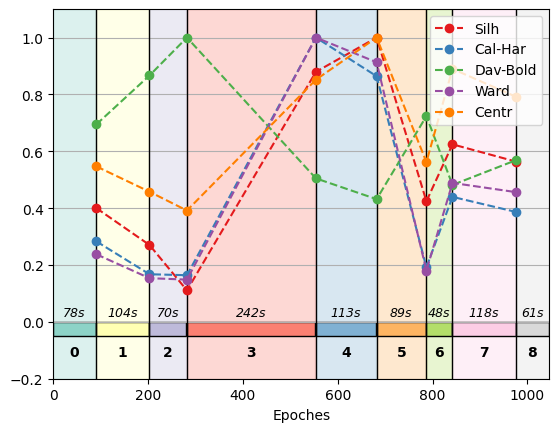

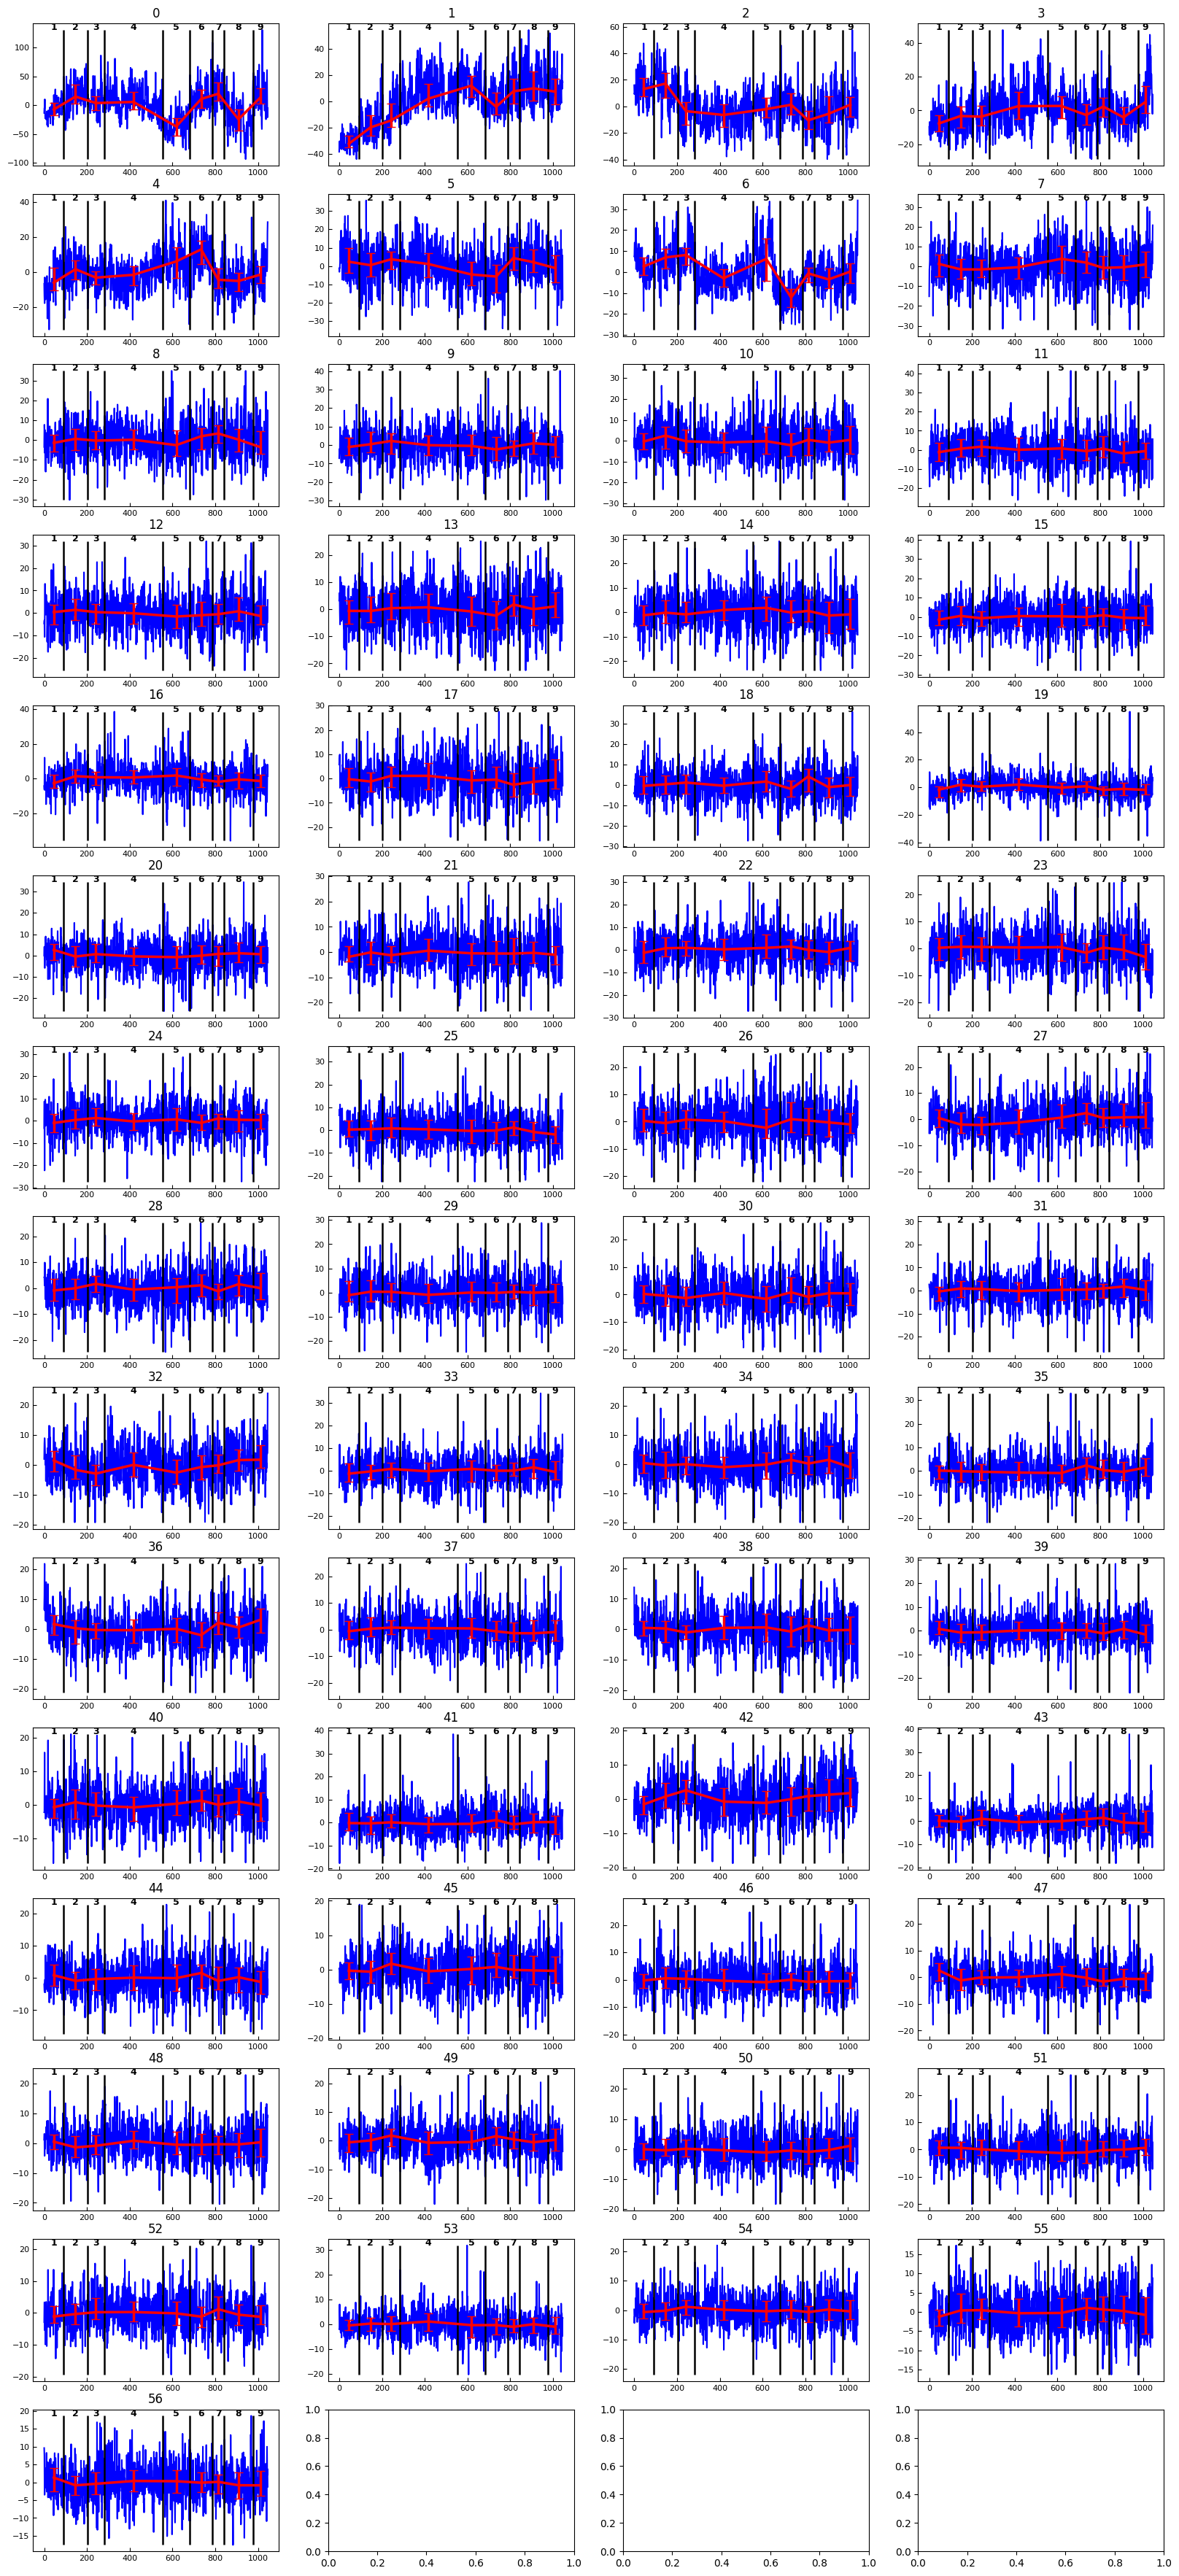

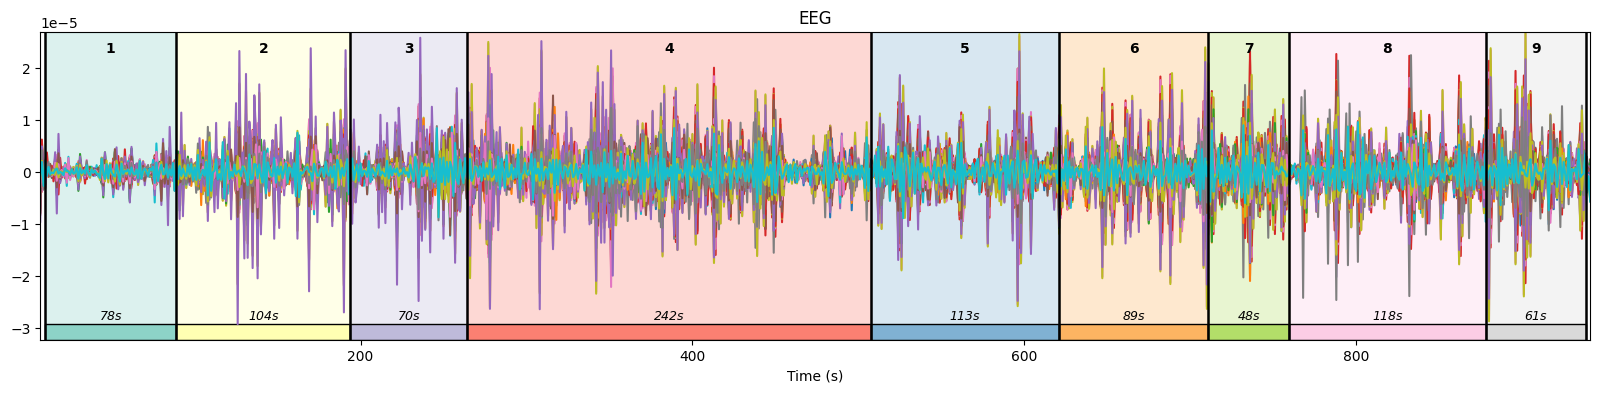

In [9]:
internal_edges = analyze(result, 'Avg-Silh', "internal")

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,20,35,15,3,Mode,"[0, 486, 682, 1046]",184942.18,36.51,2.77e-02,40.36,5.06,0.07,50.36,3.36,0.65,0.43,0.61
1,20,45,20,4,Median,"[0, 203, 554, 859, 1046]",80368.95,22.91,1.45e-02,29.36,6.68,0.04,23.88,5.98,0.69,0.49,0.61
2,60,50,15,5,Median,"[0, 200, 554, 682, 859, 1046]",167132.08,41.66,1.65e-02,38.77,5.26,0.10,48.37,2.94,0.76,0.57,0.66
3,40,40,10,6,Median,"[0, 91, 248, 546, 682, 859, 1046]",126036.45,37.26,9.54e-04,33.79,5.21,0.08,36.26,3.22,0.78,0.63,0.70
4,20,35,20,7,Mean,"[0, 93, 260, 517, 683, 832, 970, 1046]",113670.09,37.42,1.26e-03,30.35,5.76,0.08,31.96,3.15,0.80,0.70,0.74
5,0,45,10,8,Mode,"[0, 91, 248, 486, 554, 682, 842, 976, 1046]",98840.30,38.03,-4.92e-03,31.22,5.17,0.08,28.06,3.12,0.84,0.74,0.78
6,20,50,20,9,Mode,"[0, 91, 248, 282, 486, 554, 682, 842, 976, 1046]",79676.04,35.35,-6.93e-03,27.94,5.18,0.06,22.44,3.42,0.87,0.78,0.81
7,20,50,20,10,Mode,"[0, 91, 248, 282, 486, 554, 682, 787, 842, 976...",63811.66,35.39,-7.79e-03,26.28,5.14,0.06,18.16,3.39,0.89,0.82,0.84
8,0,45,20,11,Mode,"[0, 91, 248, 282, 486, 554, 682, 787, 888, 976...",57249.26,37.29,-8.18e-03,22.90,5.33,0.07,16.16,3.31,0.88,0.80,0.83
9,0,40,20,12,Mode,"[0, 91, 186, 203, 282, 486, 554, 682, 787, 842...",55137.25,38.62,-1.29e-02,22.65,4.68,0.08,15.84,3.09,0.87,0.77,0.80


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,20,50,20,9,Mode,"[0, 91, 248, 282, 486, 554, 682, 842, 976, 1046]",79676.04,35.35,-6.93e-03,27.94,5.18,0.06,22.44,3.42,0.87,0.78,0.81


array([   0,   91,  248,  282,  486,  554,  682,  842,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.04,15.44,3.63,44039.19,27.65
1,0.03,5.02,4.47,16063.88,23.97
2,0.03,4.63,4.80,14327.19,22.17
3,0.04,12.01,3.96,36702.44,26.83
4,0.05,15.87,3.16,56255.44,35.59
5,0.15,63.18,2.06,228393.88,56.67
6,0.10,40.64,2.59,150550.56,45.44
7,0.08,22.69,2.71,91075.78,44.51


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 88.3)","(89.1, 233.1)","(233.9, 263.5)","(264.3, 449.9)","(450.7, 506.7)","(507.5, 620.3)","(621.1, 758.7)","(759.5, 877.1)","(877.9, 938.7)"
"Time length, sec",78.4,144.0,29.6,185.6,56.0,112.8,137.6,117.6,60.8
Number of epochs,91,157,34,204,68,128,160,134,70


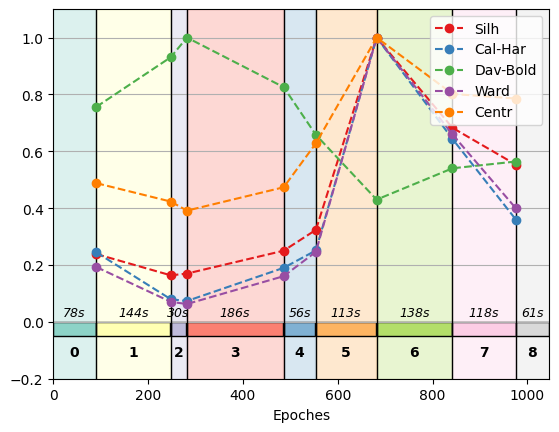

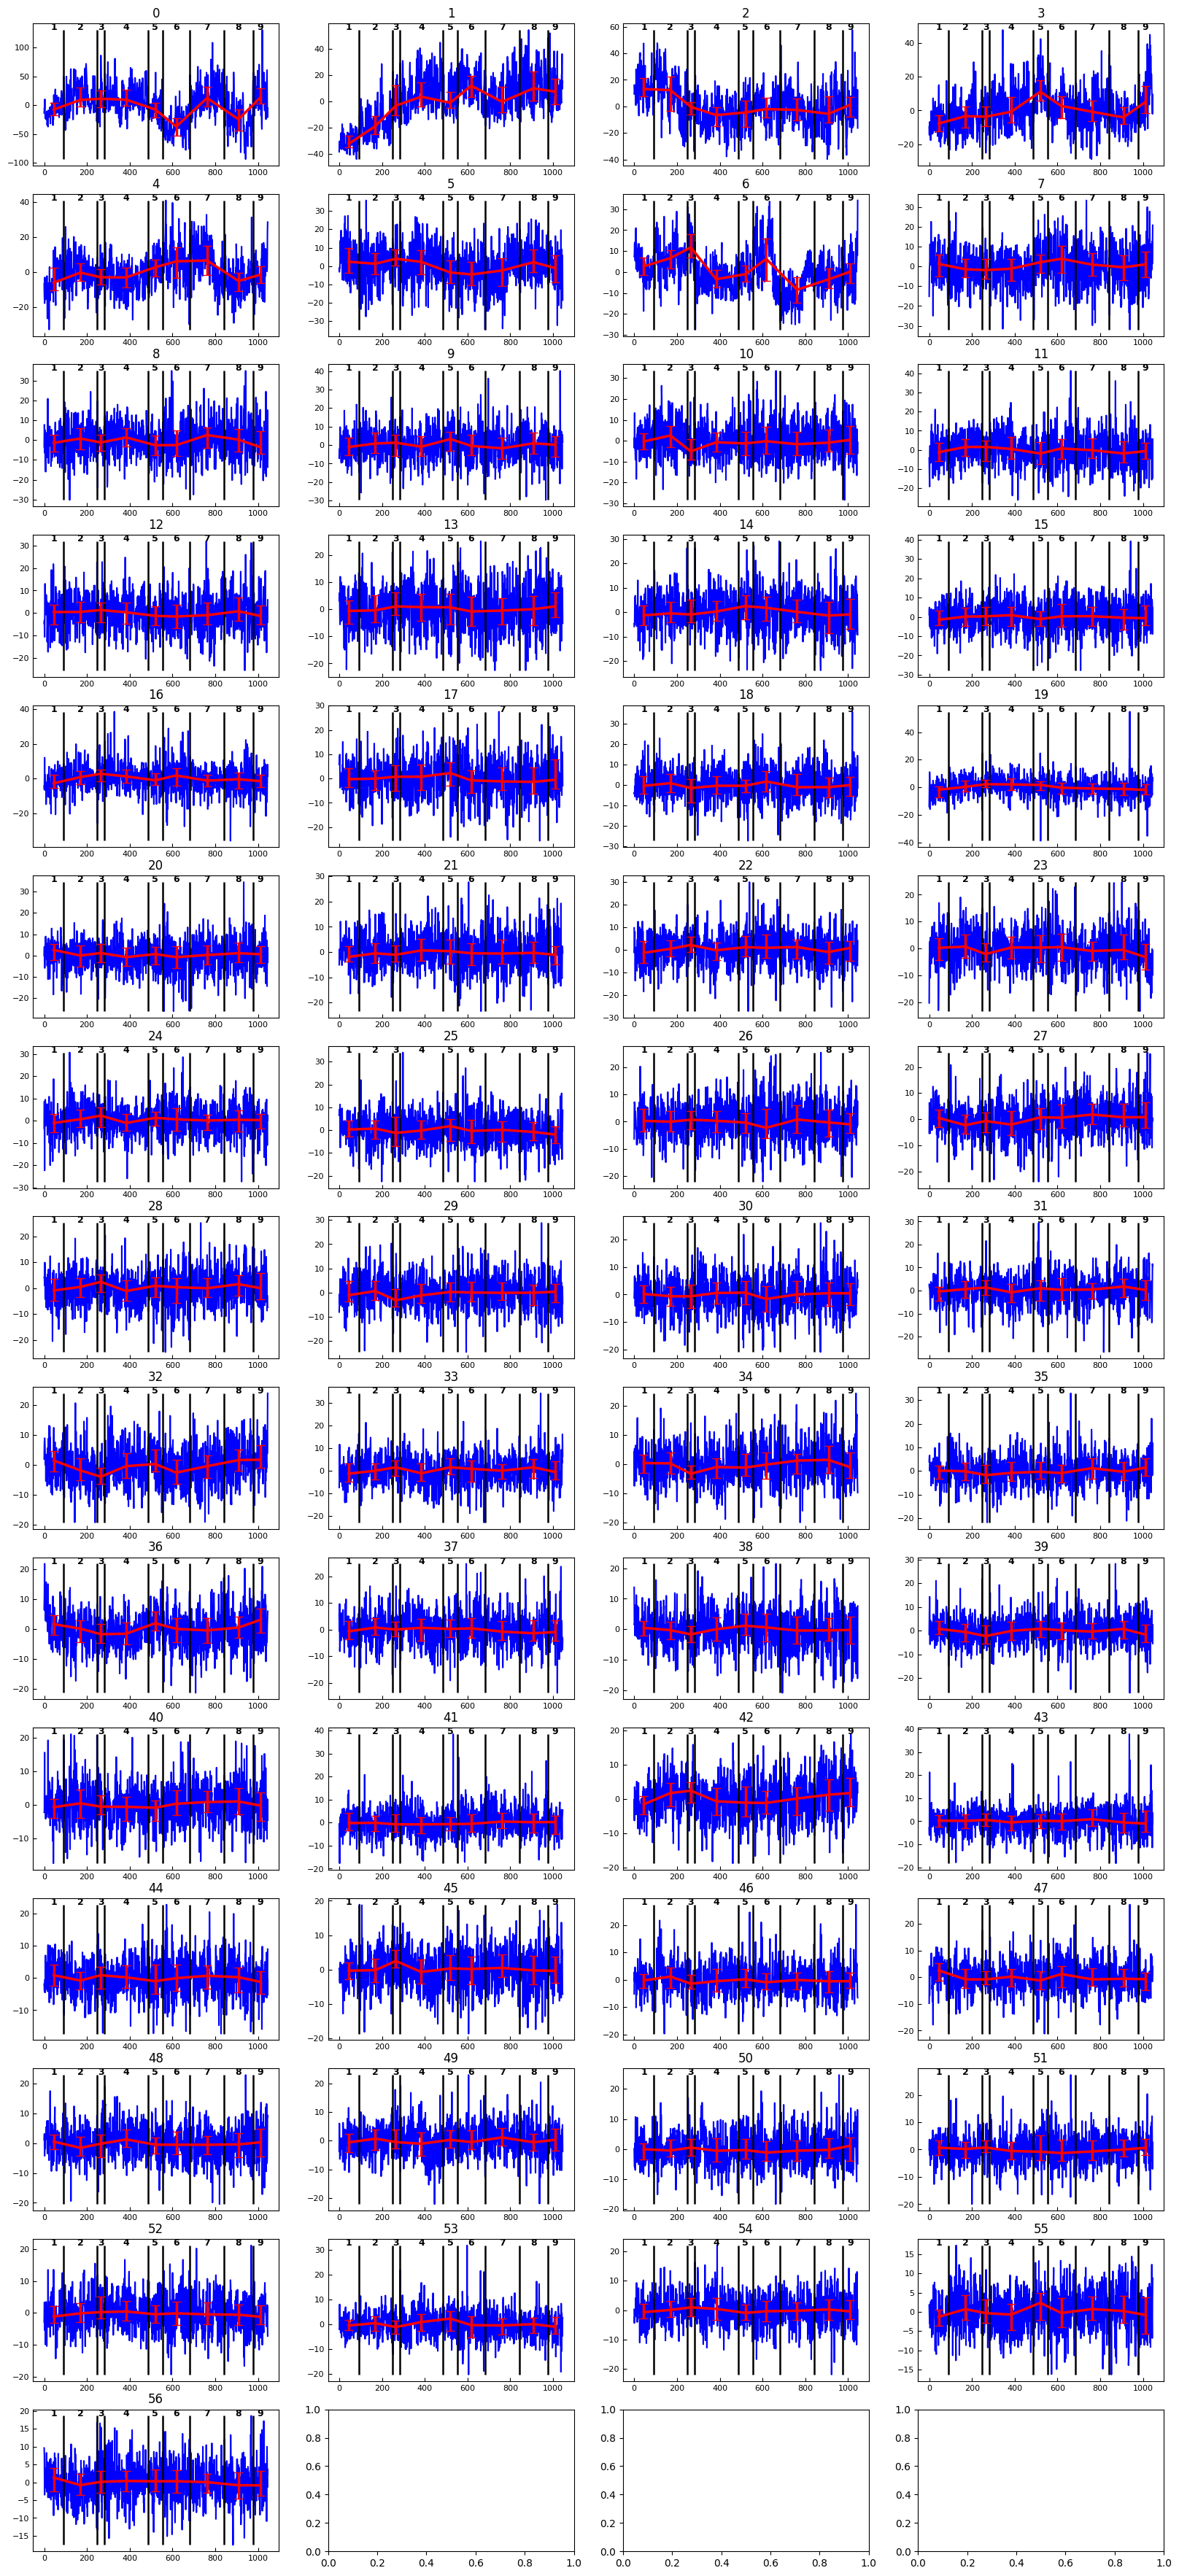

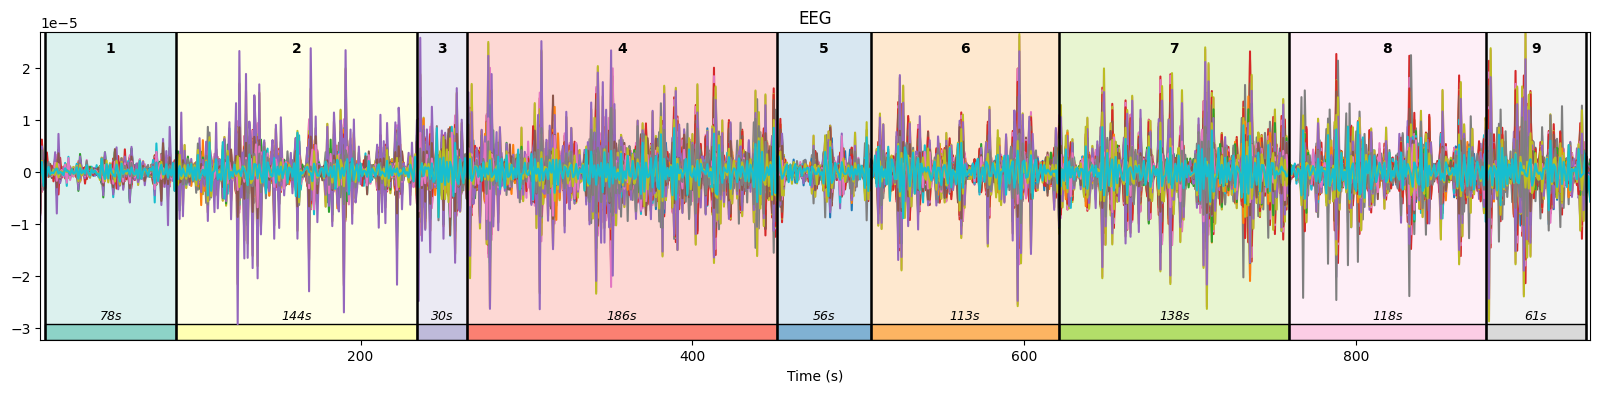

In [10]:
external_edges = analyze(result, 'FMI', "external")

### IV

In [11]:
IV = pandas.DataFrame(df_all_features.columns, columns = [ "Feature" ])
for edges, name, path in zip(
    [ edges_true, internal_edges, external_edges ],
    [ "true", "internal", "external" ],
    [ "true_iv", "internal/iv", "external/iv" ]
):
    _, labels = SDA.stageprocess.form_stage_bands(edges)
    edges_iv = SDA.analytics.IV.calc_IV_clust(df_all_features, labels)
    edges_iv.to_csv(f"{subj}/{exp}/{path}.csv")
    IV[name] = edges_iv["IV"]
IV

100%|██████████| 9875/9875 [05:07<00:00, 32.12it/s]


,Feature,true,internal,external
0,feature-0 betti-1 max,0.34,0.29,0.30
1,feature-0 betti-1 mean,0.00,0.00,0.00
2,feature-0 betti-1 std,0.44,0.39,0.40
3,feature-0 betti-1 sum,0.00,0.00,0.00
4,feature-0 betti-1 norm,0.44,0.39,0.40
...,...,...,...,...
9870,bd2-3 median,0.69,0.63,0.61
9871,bd2-3 percentile-75,0.70,0.63,0.63
9872,bd2-3 percentile-90,0.71,0.64,0.65
9873,bd2-3 kurtosis,0.15,0.15,0.11


In [12]:
IV["internal-diff"] = IV["true"] - IV["internal"]
IV["external-diff"] = IV["true"] - IV["external"]
IV.to_csv(f"{subj}/{exp}/IV.csv")
IV

,Feature,true,internal,external,internal-diff,external-diff
0,feature-0 betti-1 max,0.34,0.29,0.30,5.15e-02,0.05
1,feature-0 betti-1 mean,0.00,0.00,0.00,0.00e+00,0.00
2,feature-0 betti-1 std,0.44,0.39,0.40,4.75e-02,0.04
3,feature-0 betti-1 sum,0.00,0.00,0.00,0.00e+00,0.00
4,feature-0 betti-1 norm,0.44,0.39,0.40,4.75e-02,0.04
...,...,...,...,...,...,...
9870,bd2-3 median,0.69,0.63,0.61,5.90e-02,0.08
9871,bd2-3 percentile-75,0.70,0.63,0.63,7.95e-02,0.07
9872,bd2-3 percentile-90,0.71,0.64,0.65,6.75e-02,0.06
9873,bd2-3 kurtosis,0.15,0.15,0.11,4.06e-03,0.04


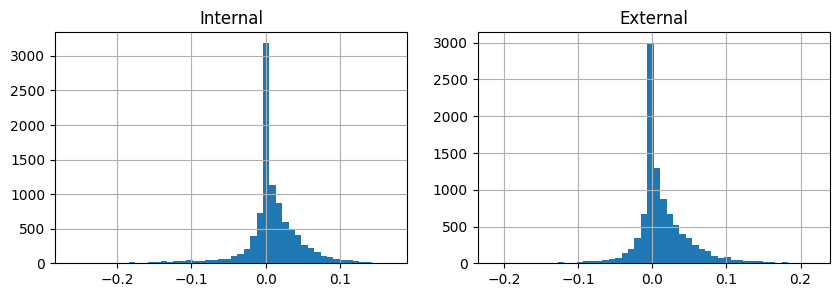

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

axes[0].set_title('Internal')
IV["internal-diff"].hist(ax = axes[0], bins = 50)

axes[1].set_title('External')
IV["external-diff"].hist(ax = axes[1], bins = 50)

plt.savefig(f"{subj}/{exp}/IV-diffs.svg")